# Phase 2: Running regressions for 1A dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

Bring in dataset:

In [199]:
master_data = pd.read_csv('2_DATA/master_data_A.csv')
master_data = master_data[master_data.beta < .0005]
master_data = master_data[master_data.f < .5]

In [200]:
master_y = master_data[['beta', 'f']] ##NO COST IN SETO DATA
master_X = master_data.drop(['Unnamed: 0','FIPS', 'POPESTIMATE2019', 'RBIRTH2019', 'beta', 'f'], axis=1)

A heatmap for the correlation of features:

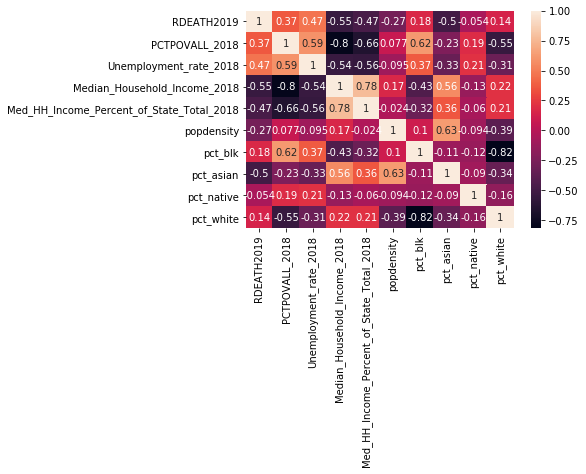

In [201]:
import seaborn as sn

corrMatrix = master_X.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [202]:
master_y['RISK'] = master_y['beta'] * master_y['f'] 
max_risk = np.amax(master_y['RISK'])
master_y['RISK'] = master_y['RISK'] / max_risk * 10

/Users/alexseto/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/alexseto/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [203]:
master_y

,beta,f,RISK
0,3.582561e-07,0.088171,0.129103
1,1.353718e-06,0.117474,0.649963
2,6.400933e-07,0.113277,0.296347
3,1.660785e-06,0.183262,1.243948
5,2.187639e-07,0.121583,0.108709
...,...,...,...
198,2.472967e-07,0.061749,0.062411
199,1.932605e-07,0.043846,0.034633
200,8.836348e-07,0.148819,0.537461
201,9.521675e-07,0.081124,0.315705


In [204]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split

risk = master_y[['RISK']]
risk.tail()
risk = np.ravel(risk)

# split test set
X, X_test, y, y_test = train_test_split(master_X, risk, test_size = .2)
print(X.shape, y.shape, X_test.shape, y_test.shape)
# split between train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)


(160, 10) (160,) (40, 10) (40,)
(120, 10) (120,) (40, 10) (40,)


Following the split of the data, we scale the rest accordingly.

In [205]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_val = scaler.fit_transform(X_val)
scaled_X_test = scaler.fit_transform(X_test)
scaled_X = scaler.fit_transform(X)


# LASSO REGRESSION

The MSE is: 0.7606847699387674


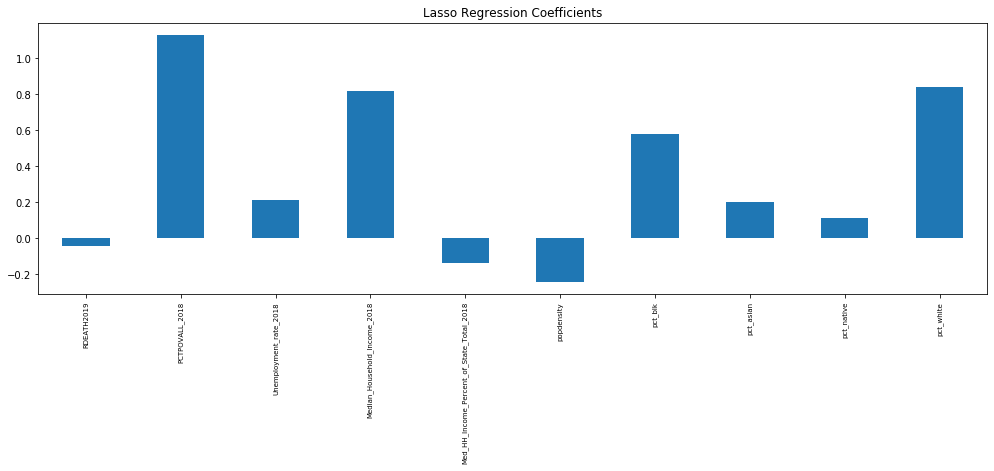

In [206]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso

from sklearn.linear_model import LassoCV

LCVmodel = LassoCV(alphas = np.linspace(.0001, 5000, 1000), cv = 5)
LCV = LCVmodel.fit(scaled_X_train, y_train)
best_alpha = LCV.alpha_
lasso_opt = Lasso(best_alpha)

lasso_opt.fit(scaled_X_train, y_train)
lasso_coefficients = lasso_opt.coef_

lasso_mse = mean_squared_error(y_val, lasso_opt.predict(scaled_X_val))
print('The MSE is:', lasso_mse)

lasso_coefs = pd.Series(lasso_opt.coef_, index=X_train.columns)
plt.figure(figsize=(17, 5))
plt.tick_params(axis='x', labelsize=7)
plt.title("Lasso Regression Coefficients")
lasso_coefs.plot(kind='bar');
plt.show()

lasso_train_score = lasso_opt.score(scaled_X_train, y_train)
lasso_val_score = lasso_opt.score(scaled_X_val, y_val)


In [207]:
print('Train Score: ', lasso_train_score)
print('Validation Score: ', lasso_val_score)
print('Test Score: ', lasso.score(scaled_X_test, y_test))

Train Score:  0.45036169560883077
Validation Score:  -0.1785110009505939
Test Score:  -2.0154348025709266


# RANDOM FOREST REGRESSOR

In [191]:
from sklearn.ensemble import RandomForestRegressor
# Enter code is this cell, or add additional cell(s) below.

rf_tree = RandomForestRegressor()
rf_tree.fit(X_train, y_train)

param_dist = {'n_estimators': randint(10, 100),
              'max_leaf_nodes': randint(3, 400),
              'max_features': ["auto"],
              'max_depth': randint(5, 10),
              'min_samples_leaf': randint(1, 30),
              'min_samples_split': randint(2, 20)}

rnd_search = RandomizedSearchCV(rf_tree, param_distributions = param_dist, cv = 10, n_iter = 50)
rnd_search.fit(X_train, y_train)

rf_tree.set_params(n_estimators = rnd_search.best_params_['n_estimators'], 
                   max_leaf_nodes = rnd_search.best_params_['max_leaf_nodes'],                  
                   max_features = rnd_search.best_params_['max_features'],
                   max_depth = rnd_search.best_params_['max_depth'],
                   min_samples_leaf = rnd_search.best_params_['min_samples_leaf'],
                   min_samples_split = rnd_search.best_params_['min_samples_split'])

rf_train_score = rf_tree.score(X_train, y_train)
rf_val_score = rf_tree.score(X_val, y_val)


print('Train Score: ', rf_train_score)
print('Validation Score: ', rf_val_score)


Train Score:  0.867474770609696
Validation Score:  0.24624628274390226
Test Score:  0.4581028695936885


Feature ranking:
0. popdensity (0.336910)
1. Med_HH_Income_Percent_of_State_Total_2018 (0.210436)
2. Median_Household_Income_2018 (0.190620)
3. PCTPOVALL_2018 (0.127647)
4. pct_asian (0.044092)
5. pct_native (0.030346)
6. pct_blk (0.020220)
7. Unemployment_rate_2018 (0.014360)
8. pct_white (0.013711)
9. RDEATH2019 (0.011659)

Train Score:  0.867474770609696
Test Score:  0.4581028695936885


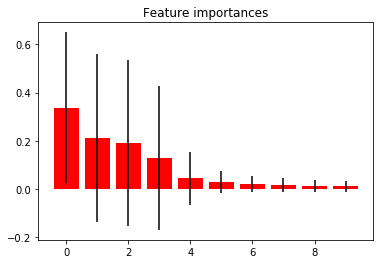

In [194]:
importances = rf_tree.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_tree.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f, X.columns[indices[f]], importances[indices[f]]))
    

print('\nTrain Score: ', rf_train_score)    
print('Test Score: ', rf_tree.score(X_test, y_test))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.show()